In [4]:
from torchvision.models import vgg19, VGG19_Weights

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import cv2
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],  # Reverse mean
    std=[1/s for s in std]                   # Reverse std
)

def denormalize_image(image_tensor):
    
    return denormalize(image_tensor)

# Function to extract class name (second last part of folder name)
def extract_label_from_folder(folder_name):
    parts = folder_name.split('_')
    return parts[-2] if len(parts) >= 2 else folder_name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FrameLoader:

    def __init__(self, frame_size=(224, 224)):
        self.frame_size = frame_size

    def load_frames(self, frame_folder):
        #print(f"[DEBUG] Loading frames from: {frame_folder}")
        frame_files = sorted(os.listdir(frame_folder))
        #print(f"[DEBUG] Found {len(frame_files)} frame files in {frame_folder}")
        frames = []

        for frame_file in frame_files:
            frame_path = os.path.join(frame_folder, frame_file)
            frame = cv2.imread(frame_path)
            if frame is None:
                print(f"[WARNING] Failed to load frame: {frame_file}")
                continue
            frame = cv2.resize(frame, self.frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = torch.tensor(frame, dtype=torch.float32).permute(2, 0, 1) / 255.0
            frames.append(frame)

        if not frames:
            print(f"[WARNING] No frames found in {frame_folder}. Returning placeholder.")
            return torch.zeros((5, 3, *self.frame_size))

        #print(f"[DEBUG] Successfully loaded {len(frames)} frames from {frame_folder}")
        return torch.stack(frames)


class KeyframeExtractor:

    def __init__(self):
        self.vgg19 = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

    def extract_keyframes(self, frames):
        #print(f"[DEBUG] Extracting keyframes from {frames.shape[0]} frames")
        frames_tensor = frames.unsqueeze(0).view(-1, 3, 224, 224)


        frames_tensor = torch.stack([transform(f.to(device)) for f in frames])
        #print(f"[DEBUG] Transformed frames tensor shape: {frames_tensor.shape}")


        with torch.no_grad():

            features = self.vgg19(frames_tensor)


        features=features.mean(dim=[2,3]).cpu().numpy()


        #print(f"[DEBUG] Extracted features of shape: {features.shape}")


        num_samples = frames.shape[0]
        num_features = features.shape[1] if len(features.shape) > 1 else 1
        #print(num_samples)
        #print(num_features)
        #print(features.shape)

        
        pca = PCA(n_components=0.95)
        reduced_features = pca.fit_transform(features)
        explained_variance = pca.explained_variance_ratio_.sum()
        #print(f"Explained variance with 20 components: {explained_variance:.2f}")

        num_cluster=10
        #print(f"[DEBUG] Applying KMeans with {num_clusters} clusters")
        kmeans = KMeans(n_clusters=num_cluster, n_init=10, random_state=42)
        kmeans.fit(reduced_features)
       


        keyframe_indices = [np.argmin(np.linalg.norm(reduced_features - center, axis=1)) for center in kmeans.cluster_centers_]
        #print(f"[DEBUG] Selected keyframe indices: {keyframe_indices}")

        keyframe_indices = sorted(keyframe_indices)
        #print(f"[DEBUG] Sorted keyframe indices: {keyframe_indices}")

        keyframes = [frames[i] for i in keyframe_indices]

        while len(keyframes) < 10:
            print(f"[DEBUG] Padding keyframes to ensure 10 frames")
            keyframes.append(keyframes[-1])

        return torch.stack(keyframes[:10])

class HandGestureDataset(Dataset):

    def __init__(self, frames_root, label_map, transform=None, save_keyframes_dir=None):
        self.frames_root = frames_root
        self.transform = transform
        self.save_keyframes_dir = save_keyframes_dir
        self.frame_loader = FrameLoader()
        self.keyframe_extractor = KeyframeExtractor()
        self.video_folders, self.labels = self.load_frame_folders(label_map)

        if self.save_keyframes_dir and not os.path.exists(self.save_keyframes_dir):
            os.makedirs(self.save_keyframes_dir)

    def load_frame_folders(self, label_map):
        #print(f"[DEBUG] Loading frame folders from: {self.frames_root}")
        video_folders = []
        labels = []

        for folder_name in os.listdir(self.frames_root):
            folder_path = os.path.join(self.frames_root, folder_name)
            if not os.path.isdir(folder_path):
                print(f"[WARNING] Skipping non-folder: {folder_name}")
                continue

            class_name = extract_label_from_folder(folder_name)
            if class_name not in label_map:
                print(f"[WARNING] Skipping unknown class: {class_name} for {folder_name}")
                continue

            video_folders.append(folder_path)
            labels.append(label_map[class_name])

        print(f"[DEBUG] Total video folders loaded: {len(video_folders)}")
        return video_folders, labels

    def __len__(self):
        return len(self.video_folders)

    def __getitem__(self, idx):
        save_path = os.path.join(self.save_keyframes_dir, f"video_{idx}.pt")

        if self.save_keyframes_dir and os.path.exists(save_path):
            #print(f"[DEBUG] Loading preprocessed keyframes from {save_path}")
            data = torch.load(save_path,weights_only=True)
            return data["keyframes"], data["label"]

        #print(f"[DEBUG] Accessing item at index: {idx}")
        frame_folder = self.video_folders[idx]
        frames = self.frame_loader.load_frames(frame_folder)
        keyframes = self.keyframe_extractor.extract_keyframes(frames)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            keyframes = torch.stack([self.transform(frame.float()) for frame in keyframes])

        if self.save_keyframes_dir:
            self.save_keyframes(keyframes, label, idx)

        return keyframes, label

    def save_keyframes(self, keyframes, label, idx):
        save_path = os.path.join(self.save_keyframes_dir, f"video_{idx}.pt")
        torch.save({"keyframes": keyframes, "label": label}, save_path)
        print(f"[DEBUG] Saved keyframes and label to {save_path}")

    def visualize_keyframes(self, keyframes):
        plt.figure(figsize=(15, 5))
        for i, frame in enumerate(keyframes):
            frame = denormalize_image(frame)
            frame = frame.permute(1, 2, 0).numpy()
            plt.subplot(1, 10, i + 1)
            plt.imshow(frame)
            plt.title(f"Keyframe {i + 1}")
            plt.axis("off")
        plt.show()




In [6]:
# Load label map
def load_label_map(label_map_path):
    with open(label_map_path, "r") as f:
        label_map = json.load(f)
    return label_map

In [7]:
import json
label_map_path = r"C:\Users\hp\Downloads\final project\label_map1.json"
label_map = load_label_map(label_map_path)

In [8]:
print(label_map)

{'BYE': 0, 'ENJOY': 1, 'H': 2, 'Hello': 3, 'J': 4, 'Morning': 5, 'Rain': 6, 'WIND': 7, 'WORK': 8, 'Y': 9}


In [34]:
train_frames_root = r"project/train/train"


In [35]:
val_frames_root= r"project/val/val"
test_frames_root = r"project/test/test"

In [47]:
transform = transforms.Compose([
    #transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
train_dataset = HandGestureDataset(train_frames_root, label_map, transform=transform, save_keyframes_dir=r"project/keyframes/train")
val_dataset = HandGestureDataset(val_frames_root, label_map, transform=transform, save_keyframes_dir=r"project/keyframes/val")
test_dataset = HandGestureDataset(test_frames_root, label_map, transform=transform, save_keyframes_dir=r"project/keyframes/test")


[DEBUG] Total video folders loaded: 668
[WARNING] Skipping unknown class: .ipynb for .ipynb_checkpoints
[DEBUG] Total video folders loaded: 140
[DEBUG] Total video folders loaded: 140


In [33]:
# Function to save keyframes for a given dataset
def save_keyframes_for_dataset(dataset):
    for idx in range(len(dataset)):
        keyframes, label = dataset[idx]
        #print(f"[DEBUG] Saving keyframes for video {idx}")
        pass



In [ ]:
save_keyframes_for_dataset(train_dataset)

In [ ]:
save_keyframes_for_dataset(val_dataset)

In [ ]:
save_keyframes_for_dataset(test_dataset)

[DEBUG] Saved keyframes and label to project/val/val/video_23.pt
[DEBUG] Final keyframes shape: torch.Size([10, 3, 224, 224])
[DEBUG] Final label: 2


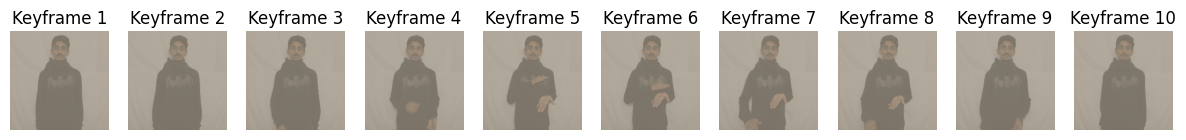

In [42]:
keyframes, label = val_dataset[23]
keyframes = denormalize_image(keyframes)
print(f"[DEBUG] Final keyframes shape: {keyframes.shape}")  
print(f"[DEBUG] Final label: {label}")  
val_dataset.visualize_keyframes(keyframes)

/tmp/ipykernel_302/2947389304.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location="cpu")
Clipping input data to the valid range for

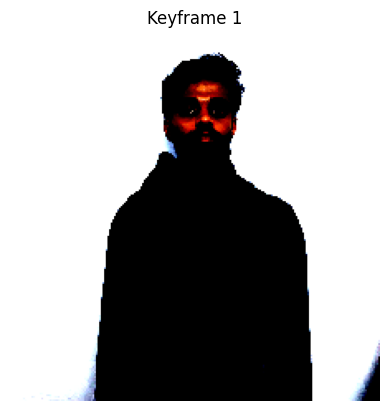

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].


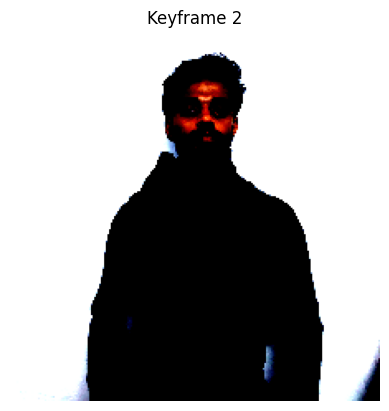

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


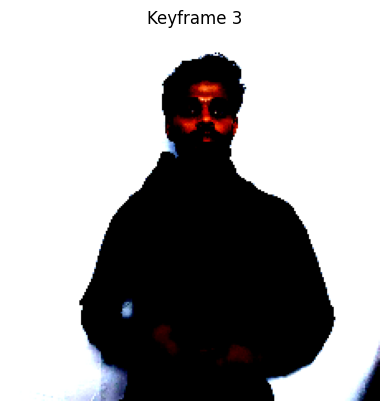

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


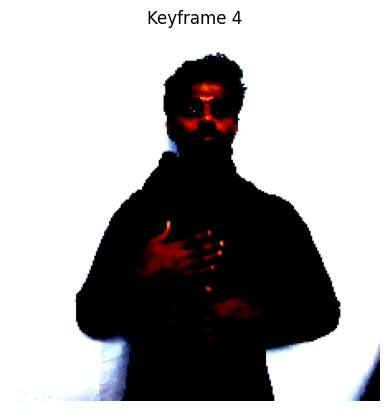

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].


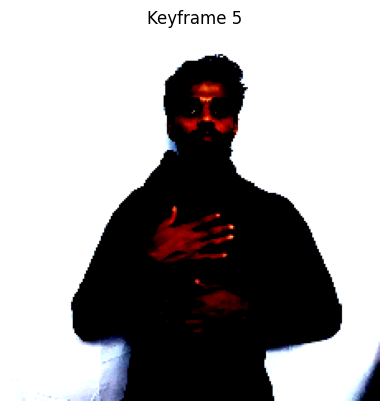

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].


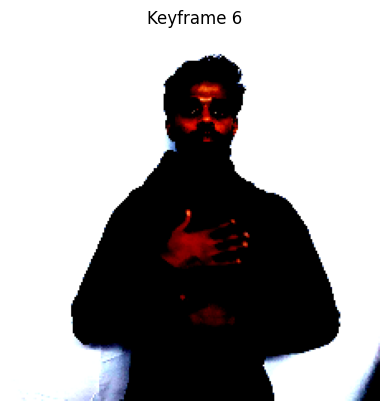

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].


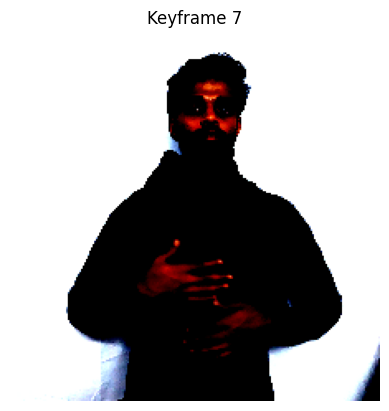

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


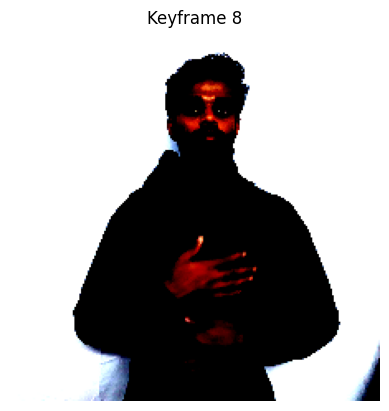

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].


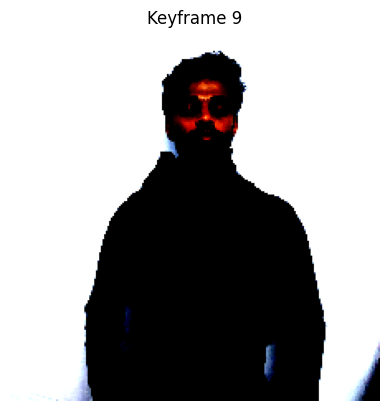

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


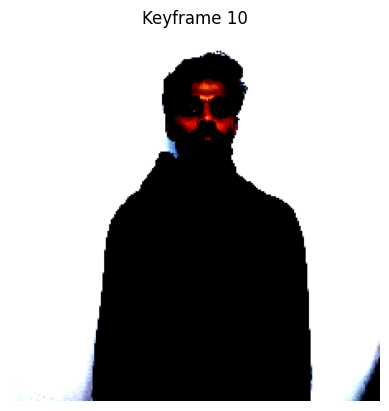

In [37]:
import torch
import matplotlib.pyplot as plt

file_path = r"keyframes/train/video_1.pt"
data = torch.load(file_path, map_location="cpu")

keyframes = data["keyframes"]  

for i, frame in enumerate(keyframes[:10]):  
    if isinstance(frame, torch.Tensor):
        img = frame.permute(1, 2, 0).cpu().numpy()  
        plt.imshow(img)
        plt.title(f"Keyframe {i+1}")
        plt.axis("off")
        plt.show()


In [9]:
import torch
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNLSTM, self).__init__()

        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            # Block 5 (new)
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
        )

        self.lstm = nn.LSTM(input_size=512 * 7 * 7, hidden_size=128, num_layers=3, batch_first=True)

        self.fc = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        c_out = c_out.view(batch_size, timesteps, -1)

        lstm_out, _ = self.lstm(c_out)

        out = self.fc(lstm_out[:, -1, :])
        return out

Using device: cuda


Epoch [1/50], Train Loss: 2.3583, Train Accuracy: 14.22%, Val Loss: 2.3055, Val Accuracy: 10.00%


Epoch [2/50], Train Loss: 2.3323, Train Accuracy: 10.03%, Val Loss: 2.2785, Val Accuracy: 18.57%


Epoch [3/50], Train Loss: 2.1841, Train Accuracy: 19.31%, Val Loss: 2.1507, Val Accuracy: 26.43%


Epoch [4/50], Train Loss: 2.0852, Train Accuracy: 21.71%, Val Loss: 1.9687, Val Accuracy: 25.00%


Epoch [5/50], Train Loss: 1.9193, Train Accuracy: 33.23%, Val Loss: 1.8182, Val Accuracy: 42.14%


Epoch [6/50], Train Loss: 1.8324, Train Accuracy: 33.83%, Val Loss: 1.7231, Val Accuracy: 45.00%


Epoch [7/50], Train Loss: 1.7510, Train Accuracy: 37.72%, Val Loss: 1.5721, Val Accuracy: 62.86%


Epoch [8/50], Train Loss: 1.6447, Train Accuracy: 47.01%, Val Loss: 1.5572, Val Accuracy: 63.57%


Epoch [9/50], Train Loss: 1.5359, Train Accuracy: 53.59%, Val Loss: 1.4964, Val Accuracy: 66.43%


Epoch [10/50], Train Loss: 1.4162, Train Accuracy: 62.57%, Val Loss: 1.3905, Val Accuracy: 68.57%


Epoch [11/50], Train Loss: 1.3523, Train Accuracy: 66.47%, Val Loss: 1.3325, Val Accuracy: 73.57%


Epoch [12/50], Train Loss: 1.2511, Train Accuracy: 72.31%, Val Loss: 1.2827, Val Accuracy: 80.00%


Epoch [13/50], Train Loss: 1.1766, Train Accuracy: 76.05%, Val Loss: 1.1896, Val Accuracy: 77.14%


Epoch [14/50], Train Loss: 1.1118, Train Accuracy: 80.84%, Val Loss: 1.0998, Val Accuracy: 75.71%


Epoch [15/50], Train Loss: 1.0436, Train Accuracy: 86.38%, Val Loss: 1.0673, Val Accuracy: 83.57%


Epoch [16/50], Train Loss: 0.9634, Train Accuracy: 87.87%, Val Loss: 0.9891, Val Accuracy: 78.57%


Epoch [17/50], Train Loss: 0.8886, Train Accuracy: 92.37%, Val Loss: 0.9827, Val Accuracy: 75.71%


Epoch [18/50], Train Loss: 0.8571, Train Accuracy: 93.41%, Val Loss: 0.9206, Val Accuracy: 85.00%


Epoch [19/50], Train Loss: 0.7924, Train Accuracy: 96.41%, Val Loss: 0.9287, Val Accuracy: 87.86%


Epoch [20/50], Train Loss: 0.7469, Train Accuracy: 96.86%, Val Loss: 0.8753, Val Accuracy: 81.43%


Epoch [21/50], Train Loss: 0.6893, Train Accuracy: 96.56%, Val Loss: 0.7750, Val Accuracy: 90.71%


Epoch [22/50], Train Loss: 0.6383, Train Accuracy: 96.86%, Val Loss: 0.8213, Val Accuracy: 86.43%


Epoch [23/50], Train Loss: 0.6281, Train Accuracy: 98.50%, Val Loss: 0.7672, Val Accuracy: 91.43%


Epoch [24/50], Train Loss: 0.5990, Train Accuracy: 98.05%, Val Loss: 0.7128, Val Accuracy: 89.29%


Epoch [25/50], Train Loss: 0.5571, Train Accuracy: 98.80%, Val Loss: 0.7546, Val Accuracy: 89.29%


Epoch [26/50], Train Loss: 0.5658, Train Accuracy: 99.10%, Val Loss: 0.6686, Val Accuracy: 89.29%


Epoch [27/50], Train Loss: 0.5272, Train Accuracy: 99.10%, Val Loss: 0.6814, Val Accuracy: 92.14%


Epoch [28/50], Train Loss: 0.5011, Train Accuracy: 99.10%, Val Loss: 0.6685, Val Accuracy: 90.71%


Epoch [29/50], Train Loss: 0.4932, Train Accuracy: 99.10%, Val Loss: 0.6415, Val Accuracy: 90.00%


Epoch [30/50], Train Loss: 0.4485, Train Accuracy: 99.40%, Val Loss: 0.6125, Val Accuracy: 91.43%


Epoch [31/50], Train Loss: 0.4560, Train Accuracy: 99.10%, Val Loss: 0.6272, Val Accuracy: 90.00%


Epoch [32/50], Train Loss: 0.4371, Train Accuracy: 99.25%, Val Loss: 0.6080, Val Accuracy: 88.57%


Epoch [33/50], Train Loss: 0.4127, Train Accuracy: 99.25%, Val Loss: 0.5745, Val Accuracy: 90.00%


Epoch [34/50], Train Loss: 0.3961, Train Accuracy: 99.25%, Val Loss: 0.5510, Val Accuracy: 92.14%


Epoch [35/50], Train Loss: 0.3857, Train Accuracy: 99.25%, Val Loss: 0.5975, Val Accuracy: 88.57%


Epoch [36/50], Train Loss: 0.3659, Train Accuracy: 99.25%, Val Loss: 0.5640, Val Accuracy: 90.71%


Epoch [37/50], Train Loss: 0.3624, Train Accuracy: 99.25%, Val Loss: 0.5314, Val Accuracy: 89.29%


Epoch [38/50], Train Loss: 0.3614, Train Accuracy: 99.10%, Val Loss: 0.5713, Val Accuracy: 87.86%


Epoch [39/50], Train Loss: 0.3441, Train Accuracy: 99.55%, Val Loss: 0.5188, Val Accuracy: 91.43%


Epoch [40/50], Train Loss: 0.3425, Train Accuracy: 99.40%, Val Loss: 0.5070, Val Accuracy: 87.14%


Epoch [41/50], Train Loss: 0.3139, Train Accuracy: 99.55%, Val Loss: 0.4727, Val Accuracy: 92.14%


Epoch [42/50], Train Loss: 0.3180, Train Accuracy: 99.55%, Val Loss: 0.4914, Val Accuracy: 92.86%


Epoch [43/50], Train Loss: 0.2877, Train Accuracy: 99.55%, Val Loss: 0.4956, Val Accuracy: 90.00%


Epoch [44/50], Train Loss: 0.2709, Train Accuracy: 99.40%, Val Loss: 0.4566, Val Accuracy: 90.71%


Epoch [45/50], Train Loss: 0.2775, Train Accuracy: 99.70%, Val Loss: 0.4969, Val Accuracy: 90.00%


Epoch [46/50], Train Loss: 0.2715, Train Accuracy: 99.55%, Val Loss: 0.5251, Val Accuracy: 90.00%


Epoch [47/50], Train Loss: 0.2704, Train Accuracy: 99.40%, Val Loss: 0.4681, Val Accuracy: 86.43%


Epoch [48/50], Train Loss: 0.2511, Train Accuracy: 99.40%, Val Loss: 0.4151, Val Accuracy: 92.86%


Epoch [49/50], Train Loss: 0.2569, Train Accuracy: 99.55%, Val Loss: 0.5247, Val Accuracy: 85.71%


Epoch [50/50], Train Loss: 0.2333, Train Accuracy: 99.25%, Val Loss: 0.4323, Val Accuracy: 91.43%
Training complete!


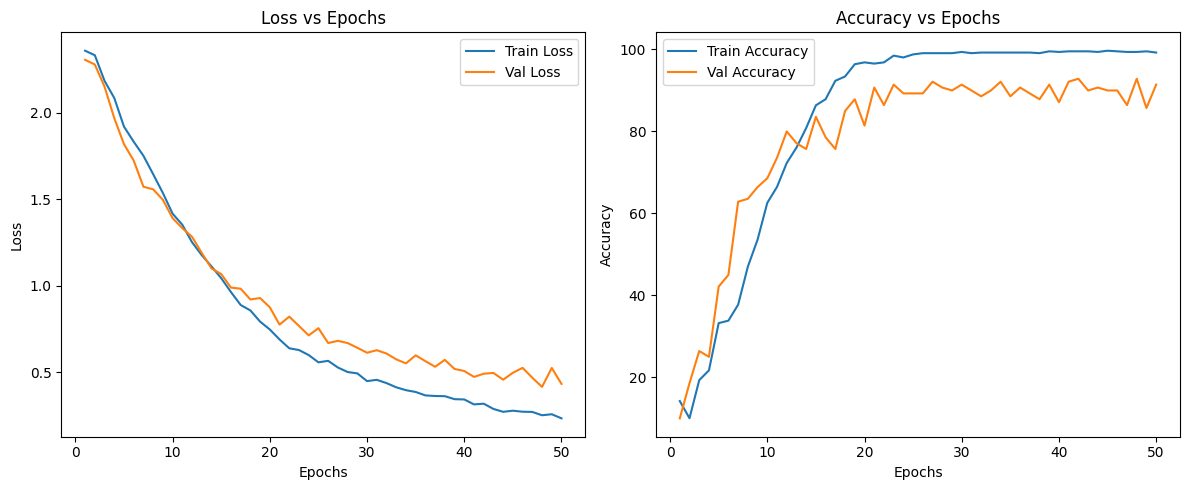

/tmp/ipykernel_206/452865812.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("project/last2.pth"))


Best Model Validation Loss: 0.4151, Validation Accuracy: 92.86%


In [61]:
import torch.optim as optim
from tqdm import tqdm


# Define early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
 
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

        if val_loss == min(val_losses):
            torch.save(model.state_dict(), "project/last2.pth")
            

    print("Training complete!")
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss vs epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    # Plot accuracy vs epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = CNNLSTM(num_classes=10).to(device)  
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-5
    )

    # Training the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=50,
        patience=5
    )

    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    model.load_state_dict(torch.load("project/last2.pth"))
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
    print(f"Best Model Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    

Using device: cuda
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.79      0.88        14
     Class 1       1.00      0.86      0.92        14
     Class 2       1.00      0.93      0.96        14
     Class 3       0.93      0.93      0.93        14
     Class 4       0.80      0.86      0.83        14
     Class 5       0.82      1.00      0.90        14
     Class 6       1.00      1.00      1.00        14
     Class 7       1.00      1.00      1.00        14
     Class 8       0.87      0.93      0.90        14
     Class 9       0.80      0.86      0.83        14

    accuracy                           0.91       140
   macro avg       0.92      0.91      0.91       140
weighted avg       0.92      0.91      0.91       140



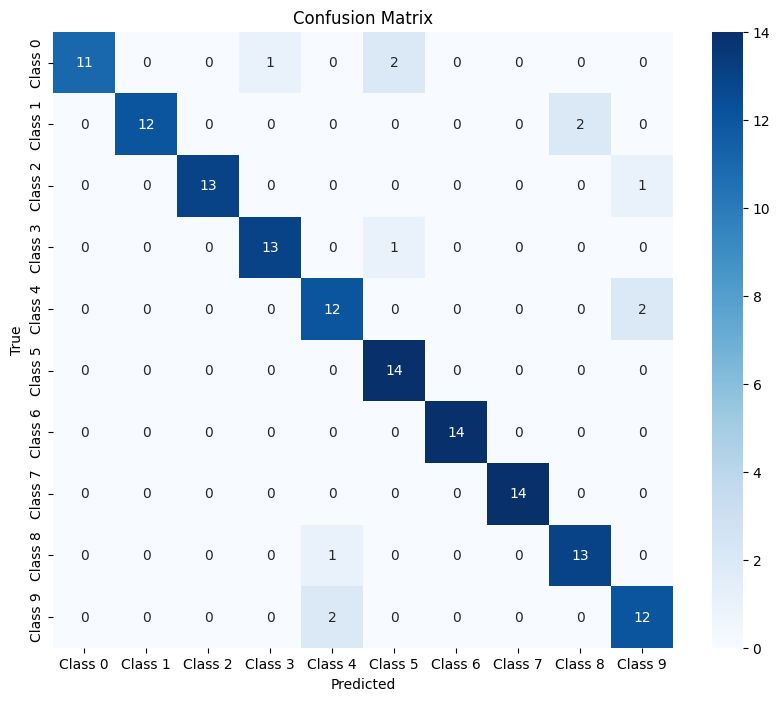

In [62]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



def test_model(model, test_loader, device):

    model.eval()  
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) 

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(10)]))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(10)],
                yticklabels=[f"Class {i}" for i in range(10)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = CNNLSTM(num_classes=10).to(device)
    model.load_state_dict(torch.load("project/last2.pth", weights_only=True))

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    test_model(model, test_loader, device)

In [10]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from PIL import Image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
video_path = r"C:\Users\hp\Downloads\CREATED DATASET\Y\video_20250430_041813_Y.mp4"
model_weights_path = r"C:\Users\hp\Downloads\last\last2.pth"     
num_clusters = 10                     
num_classes = 10                      
pca_dim = 0.95                        

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  
])

from torchvision.models import VGG19_Weights

weights = VGG19_Weights.DEFAULT  
vgg19 = models.vgg19(weights=weights).features.to(device).eval()

def extract_vgg19_features(frame):
    with torch.no_grad():
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        img = transform(pil_image).unsqueeze(0).to(device)
        features = vgg19(img)
        return features.view(-1).cpu().numpy()

def extract_keyframes_from_video(video_path, num_clusters=5):
    cap = cv2.VideoCapture(video_path)
    features = []
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        feat = extract_vgg19_features(frame)
        features.append(feat)

    cap.release()
    features = np.array(features)

    # PCA
    pca = PCA(n_components=pca_dim)
    reduced = pca.fit_transform(features)

    # KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(reduced)
    centers = kmeans.cluster_centers_
    keyframes_with_index = []

    for center in centers:
        distances = np.linalg.norm(reduced - center, axis=1)
        index = np.argmin(distances)
        keyframes_with_index.append((index, frames[index]))

    keyframes_with_index.sort(key=lambda x: x[0])
    keyframes = [f[1] for f in keyframes_with_index]

    return keyframes

def prepare_keyframes(keyframes):
    tensor_frames = []
    for f in keyframes:
        frame_rgb = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        tensor = transform(pil_image).unsqueeze(0)  
        tensor_frames.append(tensor)

    video_tensor = torch.cat(tensor_frames, dim=0).unsqueeze(0)  
    return video_tensor.to(device)



model = CNNLSTM(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')))
model.eval()

with torch.no_grad():
    keyframes = extract_keyframes_from_video(video_path, num_clusters)
    input_tensor = prepare_keyframes(keyframes)
    torch.save(input_tensor, "keyframes.pt")
    print("Keyframes saved to keyframes.pt")
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

print(f"Predicted class: {predicted.item()}")






Keyframes saved to keyframes.pt
Predicted class: 9


In [18]:
def save_keyframes(tensor, path):
    torch.save(tensor, path)
    print(f"Saved keyframes at {path}")

def load_and_visualize_keyframes(path):
    loaded_tensor = torch.load(path).squeeze(0)
    for idx in range(loaded_tensor.size(0)):
        frame = loaded_tensor[idx]
        frame = frame.permute(1, 2, 0).cpu().numpy()
        frame = frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        frame = np.clip(frame, 0, 1)
        frame = (frame * 255).astype(np.uint8)

        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.imshow(f"Keyframe {idx+1}", frame_bgr)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [19]:
load_and_visualize_keyframes(r"keyframes.pt")


In [ ]:
def run_prediction(video_path, model, num_clusters=10):
    model.eval()
    with torch.no_grad():
        keyframes = extract_keyframes_from_video(video_path, num_clusters)
        input_tensor = prepare_keyframes(keyframes)
        torch.save(input_tensor, "keyframes.pt")
        print("Keyframes saved to keyframes.pt")
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()


In [ ]:
video_path = r"C:\Users\hp\Downloads\video_20250429_201210_edit.mp4"  
model_weights_path = r"C:\Users\hp\Downloads\last\last2.pth"   

predicted_class = run_prediction(video_path, model, num_clusters=num_clusters)
print(f"Predicted class: {predicted_class}")


In [ ]:
load_and_visualize_keyframes(r"keyframes.pt")


In [ ]:
import os
import torch

def predict_on_folder(folder_path, model, num_clusters=10):

    for filename in os.listdir(folder_path):
        if filename.endswith((".mp4", ".avi", ".mov", ".mkv")):
            video_path = os.path.join(folder_path, filename)
            try:
                prediction = run_prediction(video_path, model, num_clusters)
                print(f"{filename}: Predicted class = {prediction}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")



In [ ]:
predict_on_folder(r"C:\Users\hp\Downloads\RAIN", model)


In [3]:
from torchinfo import summary

model = CNNLSTM(num_classes=10)

# Example input shape: (batch_size=1, timesteps=5, channels=3, height=224, width=224)
summary(model, input_size=(32, 10, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [32, 10]                  --
├─Sequential: 1-1                        [320, 512, 7, 7]          --
│    └─Conv2d: 2-1                       [320, 32, 224, 224]       896
│    └─BatchNorm2d: 2-2                  [320, 32, 224, 224]       64
│    └─ReLU: 2-3                         [320, 32, 224, 224]       --
│    └─Conv2d: 2-4                       [320, 32, 224, 224]       9,248
│    └─BatchNorm2d: 2-5                  [320, 32, 224, 224]       64
│    └─ReLU: 2-6                         [320, 32, 224, 224]       --
│    └─MaxPool2d: 2-7                    [320, 32, 112, 112]       --
│    └─Conv2d: 2-8                       [320, 64, 112, 112]       18,496
│    └─BatchNorm2d: 2-9                  [320, 64, 112, 112]       128
│    └─ReLU: 2-10                        [320, 64, 112, 112]       --
│    └─Conv2d: 2-11                      [320, 64, 112, 112]       36,928
│ 